In [1]:
import os
import numpy as np
import torch
from PIL import Image


class SegpcDataset(object):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted_alphanumeric(os.listdir(os.path.join(root, "x"))))
        self.masks = list(sorted_alphanumeric(os.listdir(os.path.join(root, "q"))))

    def __getitem__(self, idx):
        # load images ad masks
        #print(self.imgs[idx])
        img_path = os.path.join(self.root, "x", self.imgs[idx])
        mask_path = os.path.join(self.root, "q", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]
        #print(masks.shape)
        
        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there are two classes
        label = np.ones(num_objs)
        
        labels = torch.as_tensor(label, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

(1536, 2040)
(1536, 2040, 3)
[ 0 20 40]
masks shape:(2, 1536, 2040)


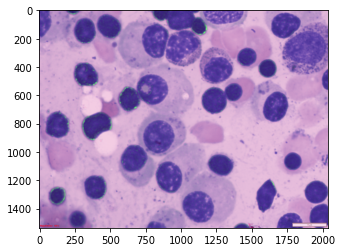

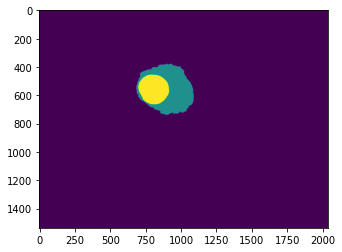

0


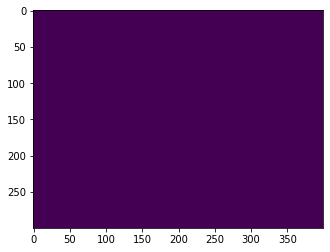

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = Image.open('/home/richards/Richards/ML/Segpc Grand Challenge/vision-master Segpc/references/detection/SegPC_2021_Train_data/train/x/2044.bmp').convert('RGB')
mask1 = Image.open('/home/richards/Richards/ML/Segpc Grand Challenge/vision-master Segpc/references/detection/SegPC_2021_Train_data/train/y/2044_5.bmp').convert('L')

img = np.array(img)
mask1 = np.array(mask1)
print(mask1.shape)
print(img.shape)

obj_ids = np.unique(mask1)
print(obj_ids)
obj_ids = obj_ids[1:]

masks = mask1 == obj_ids[:, None, None]
print('masks shape:{}'.format(masks.shape))

plt.imshow(img)
plt.show()
plt.imshow(mask1[:,:])
plt.show()
qq = mask1[0:300,800:1200]
plt.imshow(qq)
print(mask1[1500,1500])

In [3]:
import re
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

In [4]:
root='/home/richards/Richards/ML/Segpc Grand Challenge/vision-master Segpc/references/detection/SegPC_2021_Train_data/train'
masks = list(sorted_alphanumeric(os.listdir(os.path.join(root,'y'))))
#new_masks = [1920,2560]
new_masks = np.zeros((1920,2560))
l=2
mn_list=[]
mask_no=[]
for i,mask_name in enumerate(masks):
    print(mask_name)
    mask_path = os.path.join(root, "y", mask_name)
    new_mask = Image.open(mask_path)
    width,height = new_mask.size
    new_mask = np.array(new_mask)
    #print(new_mask.shape)
    #print('mask shape:{}'.format(new_mask.shape))
    #print(new_masks.shape)
    for p,k in enumerate(mask_name):
        if k=='_':
            mask_no.append(int(mask_name[0:p]))
            break
    mn_list.append(mask_no.copy())
    #print('mask_no:{}'.format(mask_no))
    #print('mn_list:{}'.format(mn_list))
    mask_no.clear()
    if i==0:
        new_mask = np.where(new_mask>0,1,new_mask)
        new_masks = new_mask
        continue
    if mn_list[-1]==mn_list[-2]:
        objests = []
        objects = np.unique(new_mask)
        print(l)
        new_mask = np.where(new_mask>0,l,new_mask)
        objects = np.unique(new_mask)
        
        for c in range(height):
            for b in range(width):
                if (new_masks[c][b]!=0):
                    continue
                else:
                    new_masks[c][b] = new_masks[c][b]+new_mask[c][b]
        l+=1
    else:
        l=2
        h,w = new_masks.shape
        im = Image.fromarray(new_masks[:h,:w])
        im = im.convert('L')
        im.save(os.path.join(root,'q',str(mn_list[-2][0])+'.bmp'))
        print(np.unique(new_masks))
        new_mask = np.where(new_mask>0,1,new_mask)
        new_masks = new_mask
        
    if i==(len(masks)-1):
        l=1
        h,w = new_masks.shape
        im = Image.fromarray(new_masks[:h,:w])
        im = im.convert('L')
        im.save(os.path.join(root,'q',str(mn_list[-2][0])+'.bmp'))
        print(np.unique(new_masks))
        new_masks = new_mask

106_1.bmp
106_2.bmp
2


KeyboardInterrupt: 

In [8]:
root='/home/richards/Richards/ML/Segpc Grand Challenge/vision-master Segpc/references/detection/SegPC_2021_Train_data/train'

masks = list(sorted_alphanumeric(os.listdir(os.path.join(root,'z'))))
for i,mask_name in enumerate(masks):
    print(i)
    print(mask_name)
    mask_path = os.path.join(root,'z',mask_name)
    mask = Image.open(mask_path)
    mask = np.array(mask)
    obj_id = np.unique(mask)
    print(obj_id)

0
106.bmp
[ 0 20 40]
1
108.bmp
[ 0 20 40]
2
109.bmp
[ 0 20 40]
3
111.bmp
[ 0 20 40]
4
112.bmp
[ 0 20 40]
5
114.bmp
[ 0 20 40]
6
201.bmp
[ 0 20 40]
7
202.bmp
[ 0 20 40]
8
210.bmp
[ 0 20 40]
9
212.bmp
[ 0 20 40]
10
213.bmp
[ 0 20 40]
11
214.bmp
[ 0 20 40]
12
215.bmp
[ 0 20 40]
13
216.bmp
[ 0 20 40]
14
303.bmp
[ 0 20 40]
15
306.bmp
[ 0 20 40]
16
307.bmp
[ 0 20 40]
17
308.bmp
[ 0 20 40]
18
408.bmp
[ 0 20 40]
19
410.bmp
[ 0 20 40]
20
411.bmp
[ 0 20 40]
21
412.bmp
[ 0 20 40]
22
413.bmp
[ 0 20 40]
23
414.bmp
[ 0 20 40]
24
416.bmp
[ 0 20 40]
25
503.bmp
[ 0 20 40]
26
504.bmp
[ 0 20 40]
27
510.bmp
[ 0 20 40]
28
517.bmp
[ 0 20 40]
29
520.bmp
[ 0 20 40]
30
601.bmp
[ 0 20 40]
31
603.bmp
[ 0 20 40]
32
606.bmp
[ 0 20 40]
33
1697.bmp
[ 0 20 40]
34
1698.bmp
[ 0 20 40]
35
1714.bmp
[ 0 20 40]
36
1722.bmp
[ 0 20 40]
37
1724.bmp
[ 0 20 40]
38
1726.bmp
[ 0 20 40]
39
1727.bmp
[ 0 20 40]
40
1730.bmp
[ 0 20 40]
41
1740.bmp
[ 0 20 40]
42
1743.bmp
[ 0 20 40]
43
1775.bmp
[ 0 20 40]
44
1778.bmp
[ 0 20 40]
45
1783.

In [16]:
masks = list(sorted_alphanumeric(os.listdir(os.path.join(root,'p'))))
image = list(sorted_alphanumeric(os.listdir(os.path.join(root,'x'))))
print(masks[30],image[30])

601.bmp 601.bmp


In [18]:
import colorsys
import random

def random_colors(N,bright=True):
    brightness = 1.0 if bright else 0.7
    hsv = [(i/N,1,brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

In [19]:
def apply_mask(image,mask,color,alpha=1):
    for c in range(3):
        image[:,:,c] = np.where(mask==1,image[:,:,c]*(1-alpha)+alpha*255*color[c],image[:,:,c])
    return image

In [20]:
def display_instances(image, boxes, masks, class_ids, class_names,
                      scores=None, title="",
                      figsize=(16, 16), ax=None,
                      show_mask=True, show_bbox=True,
                      colors=None, captions=None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    title: (optional) Figure title
    show_mask, show_bbox: To show masks and bounding boxes or not
    figsize: (optional) the size of the image
    colors: (optional) An array or colors to use with each object
    captions: (optional) A list of strings to use as captions for each object
    """
    # Number of instances
    N = boxes.shape[0]
    print('Number of boxes:{}'.format(N))
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    # If no axis is passed, create one and automatically call show()
    auto_show = False
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
        auto_show = True

    # Generate random colors
    colors = colors or random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)

    #masked_image = image.astype(np.uint32).copy()
    masked_image = image
    plt.imshow(masked_image)
    plt.show()
    for i in range(N):
        color = colors[i]

        # Bounding box
        if not np.any(boxes[i]):
            print('continue')
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        x1, y1, x2, y2 = boxes[i]
        if show_bbox:
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                alpha=0.7, linestyle="dashed",
                                edgecolor=color, facecolor='none')
            ax.add_patch(p)

        # Label
        if not captions:
            class_id = class_ids[i]
            score = scores[i] if scores is not None else None
            label = class_names[class_id]
            caption = "{} {:.3f}".format(label, score) if score else label
        else:
            caption = captions[i]
        ax.text(x1, y1 + 8, caption,
                color='w', size=11, backgroundcolor="none")

        # Mask
        mask = masks[:, :, i]
        if show_mask:
            masked_image = apply_mask(masked_image, mask, color)

        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        padded_mask = np.zeros(
            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor=color)
            ax.add_patch(p)
    #ax.imshow(masked_image.astype(np.uint8))
    ax.imshow(masked_image)
    if auto_show:
        plt.show()

0
torch.Size([3, 1536, 2040])
Number of boxes:5


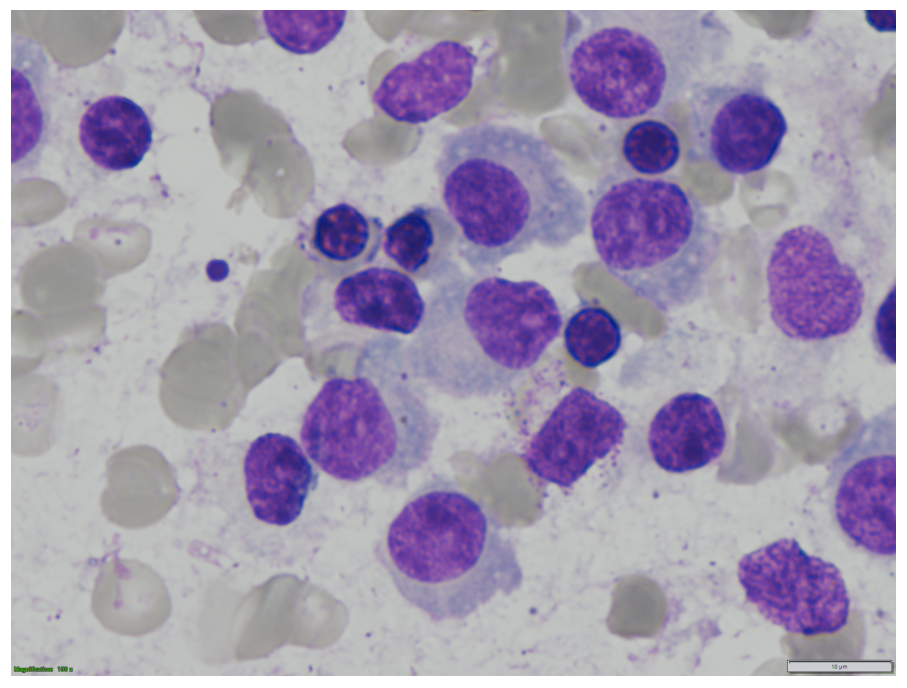

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
torch.Size([3, 1536, 2040])
Number of boxes:4


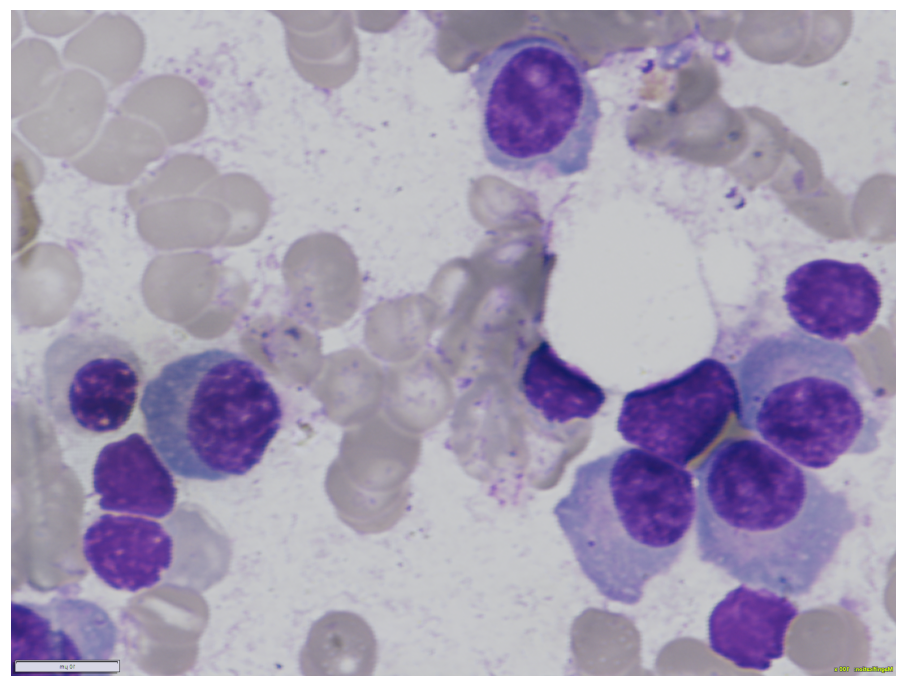

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
torch.Size([3, 1536, 2040])
Number of boxes:3


KeyboardInterrupt: 

In [21]:
import transforms as T
import utils
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage.measure import find_contours
from matplotlib.patches import Polygon

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)
dataset = SegpcDataset('/home/richards/Richards/ML/Segpc Grand Challenge/vision-master Segpc/references/detection/SegPC_2021_Train_data/train', get_transform(train=True))

data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=1, shuffle=True, num_workers=1,
        collate_fn=utils.collate_fn)

i=0
for images,targets in data_loader:
    for i,image in enumerate(images):
        print(i)
        print(image.shape)
        target = targets[i]
        #print(target)
        image = image.numpy()
        image = image.transpose(1,2,0)
        masks = target['masks']
        #print('masks shape:{}'.format(masks.shape))
        masks = masks.numpy()
        masks = masks.transpose(1,2,0)
        target['boxes']=np.array(target['boxes'])
        target['labels']=np.array(target['labels'])
        #print(target['boxes'].shape[0],target['masks'].shape,target['labels'].shape[0])
        display_instances(image, target['boxes'], masks, target['labels'], ['bg','nucleus','cytoplasm'],
                          scores=None, title="",
                          figsize=(16, 16), ax=None,
                          show_mask=True, show_bbox=True,
                          colors=None, captions=None)


In [3]:
import transforms as T
import utils
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage.measure import find_contours
from matplotlib.patches import Polygon

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)
dataset = SegpcDataset('/home/richards/Richards/ML/Segpc Grand Challenge/vision-master Segpc/references/detection/SegPC_2021_Train_data/train', get_transform(train=True))

data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=2, shuffle=True, num_workers=1,
        collate_fn=utils.collate_fn)

i=0
for images,targets in data_loader:
    for i,image in enumerate(images):
        target = targets[i]
        masks = target['masks']
        masks = masks.numpy()
        masks = masks.transpose(1,2,0)
        #print('masks shape:{}'.format(masks.shape))

9901.bmp
(14, 1536, 2040)
2336.bmp
(14, 1536, 2040)
9713.bmp
(6, 1536, 2040)
2274.bmp
(20, 1536, 2040)
601.bmp
(6, 1920, 2560)
9668.bmp
(16, 1536, 2040)
9449.bmp
(2, 1536, 2040)
9424.bmp
(22, 1536, 2040)
2050.bmp
(16, 1536, 2040)
9785.bmp
(16, 1536, 2040)
9634.bmp
(14, 1536, 2040)
1730.bmp
(12, 1536, 2040)
416.bmp
(4, 1920, 2560)
210.bmp
(10, 1920, 2560)
9410.bmp
(6, 1536, 2040)
1985.bmp
(8, 1536, 2040)
1775.bmp
(16, 1536, 2040)
303.bmp
(10, 1920, 2560)
9579.bmp
(2, 1536, 2040)
2009.bmp
(4, 1536, 2040)
2032.bmp
(8, 1536, 2040)
9333.bmp
(12, 1536, 2040)
510.bmp
(12, 1920, 2560)
2250.bmp
(18, 1536, 2040)
9671.bmp
(8, 1536, 2040)
2143.bmp
(12, 1536, 2040)
1962.bmp
(6, 1536, 2040)
1940.bmp
(8, 1536, 2040)
9815.bmp
(6, 1536, 2040)
520.bmp
(4, 1920, 2560)
2085.bmp
(12, 1536, 2040)
2209.bmp
(16, 1536, 2040)
1835.bmp
(24, 1536, 2040)
1800.bmp
(16, 1536, 2040)
1859.bmp
(16, 1536, 2040)
1862.bmp
(12, 1536, 2040)
9874.bmp
(4, 1536, 2040)
1935.bmp
(12, 1536, 2040)
9736.bmp
(4, 1536, 2040)
9489.bmp

ValueError: Caught ValueError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/richards/.local/lib/python3.6/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/richards/.local/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/richards/.local/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "<ipython-input-1-585b6454ef71>", line 39, in __getitem__
    masks = masks[:k]+masks[k:]
ValueError: operands could not be broadcast together with shapes (7,1536,2040) (8,1536,2040) 


9383.bmp
(6, 1536, 2040)
202.bmp
(12, 1920, 2560)
2272.bmp
(8, 1536, 2040)


In [7]:
import transforms as T
import utils
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage.measure import find_contours
from matplotlib.patches import Polygon
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)
dataset = SegpcDataset('/home/richards/Richards/ML/Segpc Grand Challenge/vision-master Segpc/references/detection/SegPC_2021_Train_data/train', get_transform(train=True))

data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=1, shuffle=True, num_workers=1,
        collate_fn=utils.collate_fn)

i=0
for images,targets in data_loader:
    target = targets[0]
    boxes = target['boxes']
    for box in boxes:
        width = box[2]-box[0]
        height = box[3]-box[1]
        if width<1 or height<1:
            print(i)
            print('!!!!!!!')
    i+=1

FileNotFoundError: Caught FileNotFoundError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/richards/.local/lib/python3.6/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/richards/.local/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/richards/.local/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "<ipython-input-2-fead38ff047e>", line 23, in __getitem__
    mask = Image.open(mask_path)
  File "/home/richards/.local/lib/python3.6/site-packages/PIL/Image.py", line 2891, in open
    fp = builtins.open(filename, "rb")
FileNotFoundError: [Errno 2] No such file or directory: '/home/richards/Richards/ML/Segpc Grand Challenge/vision-master Segpc/references/detection/SegPC_2021_Train_data/train/q/2138.bmp'
